In [1]:
import os
import numpy as np
from tqdm import tqdm
from pymatgen.core import Structure
from pymatgen.io.vasp.outputs import Vasprun, Chgcar, Oszicar, Outcar, Potcar
from siman.calc_manage import smart_structure_read

from itertools import combinations
from scipy.constants import physical_constants
from itertools import combinations
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

k_B = physical_constants['Boltzmann constant in eV/K'][0]

def get_ratio(path_to_structure : str, initial_atoms_num : float) -> float:
    tmp_strucuture = Structure.from_file(path_to_structure)
    ratio = len(tmp_strucuture) / initial_atoms_num
    return ratio


def count_nn(path_to_poscar: str, magnetic_atoms: list) -> dict:
    """
    calculated the number of nearest neighbors,
    to fit into the Heisenberg model.
    Get a path to POSCAR structure as an input,
    To avoid errors one should use prettified POSCAR,
    use poscar_prettifier() function first.

    Args:
        poscar_path     (str)  - path to the POSCAR file
        magnetic_atoms  (list) - two type of atoms to be treated as a magnetic
                            with an opposite spins (up/down).
                            your POSCAR should contain this two types of atoms.
    Returns:
        dict{distance : number_of_neibours}
    """
    if not os.path.exists(path_to_poscar):
        print(f'File {path_to_poscar} does not exist!')
        return None
    st = smart_structure_read(path_to_poscar)
    st = st.replic([6, 6, 6])
    out = st.nn(i=1, n=500, silent=1)

    a = list(zip(out['el'][1:], out['dist'][1:]))
    # collect all the unique distances
    unique_dist = set(round(i[1], 3) for i in a if i[0] in magnetic_atoms)
    magnetic_dist_lst = [(el, round(dist, 3)) for el, dist in a if el in magnetic_atoms]

    dist_neighbNum = {_: 0 for _ in unique_dist}  # key- distane, value list of
    # neighbours at 1st 2nd 3d coordination spheres

    for dist in unique_dist:
        for el, distance in magnetic_dist_lst:
            if dist == distance:
                if el == magnetic_atoms[0]:
                    dist_neighbNum[dist] += 1
                elif el == magnetic_atoms[1]:
                    dist_neighbNum[dist] -= 1
    return dist_neighbNum

def get_nn_list(path_to_poscar : str, magnetic_atom : str) -> list:
    nn_list = list(count_nn(path_to_poscar, magnetic_atoms=[magnetic_atom, 'Po']).values())
    return nn_list


def is_good_structure(struct_folder : str) -> bool:
    """
    
    Check if structures after relaxation are sutable for
    futher Heisenberg hamiltonian calculations
    
    Return:
        True/False
        
    """
    
    vasprun_path = os.path.join(struct_folder, 'vasprun.xml')
    osz_path = os.path.join(struct_folder, 'OSZICAR')
    assert os.path.exists(vasprun_path), 'File vasprun.xml absent! Cant continue :('
    assert os.path.exists(osz_path), 'File OSZICAR absent! Cant continue :('

    try:
        vasprun = Vasprun(vasprun_path, parse_dos=False, parse_eigen=False)
    except Exception:
        return False

    osz = Oszicar(osz_path)
    mag_mom = abs(osz.ionic_steps[-1]['mag'])

    mag_crit = False
    converg_crit = False

    if os.path.basename(struct_folder) == 'fm0' and mag_mom > 1.0:
        mag_crit = True

    if os.path.basename(struct_folder) != 'fm0' and mag_mom < 0.1:
        mag_crit = True

    if vasprun.converged * vasprun.converged_electronic * vasprun.converged_ionic :
        converg_crit = True

    return bool(converg_crit * mag_crit)


def find_good_structures(input_path : str) -> list:
    good_struct_list = []
    bad_struct_list = []

    vasp_inputs_path = os.path.join(input_path, 'vasp_inputs')

    assert os.path.exists(vasp_inputs_path), f'Path "{vasp_inputs_path}" Does not exist!'

    for magnetic_conf in os.listdir(vasp_inputs_path):
        struct_folder = os.path.join(vasp_inputs_path, magnetic_conf)
        if is_good_structure(struct_folder):
            good_struct_list.append(struct_folder)
        else:
            bad_struct_list.append(struct_folder)
    return good_struct_list, bad_struct_list

def energy_list_getter(good_struct_list : list, initial_atoms_num : int) -> list:
    E_list = []
    for struct_folder in tqdm(good_struct_list):
        vasprun_path = os.path.join(struct_folder, 'vasprun.xml')
        poscar_path = os.path.join(struct_folder, 'POSCAR')
        vasprun = Vasprun(vasprun_path, parse_dos=False, parse_eigen=False)
        ratio = get_ratio(poscar_path, initial_atoms_num)
        E_tot = vasprun.final_energy / ratio
        E_list.append(E_tot)
    return np.array(E_list)

def nn_matrix_getter(good_struct_list : list, magnetic_atom : str) -> list:
    good_structures_number = len(good_struct_list)
    nn_matrix = []
    for struct_folder in tqdm(good_struct_list): 
        siman_path = os.path.join(input_path, 'siman_inputs', f'POSCAR_{struct_folder.split("/")[-1]}')
        nn_list = get_nn_list(path_to_poscar = siman_path, magnetic_atom=magnetic_atom)
        nn_matrix.append(nn_list[:good_structures_number - 1])
    nn_matrix = np.append(np.ones([len(nn_matrix), 1]), nn_matrix, 1)
    return np.array(nn_matrix)

def sorted_matrix_getter(input_path : str) -> list:
    good_struct_list, bad_struct_list = find_good_structures(input_path)
    initial_atoms_num = len(Structure.from_file(os.path.join(input_path, 'POSCAR')))
    E_list = energy_list_getter(good_struct_list, initial_atoms_num)
    nn_matrix = nn_matrix_getter(good_struct_list, magnetic_atom)
    nn_spin_matrix = nn_matrix * spin * (spin + 1)
    full_matrix = np.append(nn_spin_matrix, E_list.reshape(len(E_list),1), axis=1)
    sorted_matrix = full_matrix[np.argsort(full_matrix[:,-1])]
    return nn_matrix, sorted_matrix, good_struct_list, bad_struct_list

def exchange_coupling(matrix:list, energies: list) -> list:
    determinant = np.linalg.det(matrix)
    if determinant:
        solution_vector = np.linalg.solve(matrix, energies)
        return abs(solution_vector)

def j_vector_list_getter(sorted_matrix : list) -> list:
    energies = sorted_matrix[...,-1]
    matrix = sorted_matrix[...,:-1]

    matrix_size = matrix.shape[0]
    results = []
    for i in range(2, matrix_size + 1):
        tmp_matrix = matrix[:i,:i]
        tmp_energies = energies[:i]
        solution_vector = exchange_coupling(tmp_matrix, tmp_energies)
        if solution_vector is not None:
            results.append(solution_vector)

    E_geom_list = np.array([i[0] for i in results])
    j_vectors_list = [i[1:] for i in results]
    return E_geom_list, j_vectors_list

def Tc_list_getter(j_vector_list : list, z_vector : list) -> list:
    T_c_list = []
    for j_vector in j_vector_list:
        z_vector_tmp = z_vector[:len(j_vector)]
        T_c = round(sum(j_vector * z_vector_tmp) / (3 * k_B), 1)
        T_c_list.append(T_c)
    T_c_list = np.array(T_c_list)
    return T_c_list

def write_output(j_vector_list, good_struct_list, bad_struct_list, nn_matrix, E_geom, Tc_list):
    j_out_str = 'Exchange coupling vector J, meV: \n \n'
    for i in j_vector_list:
        tmp_out_str = str(len(i)) + ' : ' +  str(np.round(i * 1000, 2)) + '\n' 
        j_out_str += tmp_out_str

    output_text = f"""
    good_struct_list
        {good_struct_list}

    bad_struct_list    
        {bad_struct_list}

    nn_matrix:
        {nn_matrix}

    E_geom, eV:
        {E_geom}
        
        {j_out_str}

    Raw Tc_list, K:
        {Tc_list}

    Estimated value of Tc, K:    
        {round(Tc_list.mean())} K
        """

    out_path = os.path.join(input_path, 'OUTPUT.txt')
    with open(out_path, 'w') as out_f:
        out_f.writelines(output_text)

def plot_j_values(j_vector_list : list, input_path : str) -> None:
    plt.figure(figsize=(7,5), dpi=100)
    j_vector_list_mev = [i * 1000 for i in j_vector_list]
    for y in j_vector_list_mev:
        x = range(1, len(y) + 1)
        plt.plot(x, y)
        plt.scatter(x, y, label=len(x))
    plt.xlabel('Coordination sphere number', fontsize = 14)
    plt.ylabel('J, meV', fontsize = 14)
    plt.xticks(range(1, len(j_vector_list[-1]) + 1))
    plt.grid(alpha=.4)
    plt.legend()
    plt.savefig(os.path.join(input_path, 'J_vectors_plot.pdf'), bbox_inches='tight')

def plot_E_tot(sorted_matrix : list, nn_matrix : list) -> None:
    
    E_tot_mev = np.array([i[-1] * 1000 for i in sorted_matrix])
    E_tot_norm = E_tot_mev - E_tot_mev.min()
    max_E_geom = max(E_tot_mev)
    min_E_geom = min(E_tot_mev)
    dE_geom = max_E_geom - min_E_geom
    text = f"""
    $dE$    :  {dE_geom:.2f}   meV
    max : {max_E_geom:.2f}  meV
    min  : {min_E_geom:.2f}   meV
    """
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    
    x = range(1, len(E_tot_norm) + 1)
    plt.figure(figsize=(7, 5), dpi=100)
    plt.scatter(x, E_tot_norm, color='r')
    plt.plot(x, E_tot_norm, color='r')
    plt.text(1, max(E_tot_norm), text, verticalalignment='top', bbox=props)
    plt.grid(alpha=.4)
    plt.xlabel('Spins (\u2191 - \u2193)', fontsize =14)
    plt.ylabel(r'$E_{tot},  meV$', fontsize =14)
    combination_list = [[int(p) for p in i[1:6]] for i in nn_matrix]
    plt.xticks(x, combination_list, rotation=10, ha='right')
    plt.savefig(os.path.join(input_path, 'E_tot_plot.pdf'), bbox_inches='tight')

def solver(input_path: str, magnetic_atom: str, spin: float):
    nn_matrix, sorted_matrix, good_struct_list, bad_struct_list = sorted_matrix_getter(input_path)
    E_geom, j_vector_list = j_vector_list_getter(sorted_matrix)

    z_vector = get_nn_list(path_to_poscar = os.path.join(input_path, 'POSCAR'),
                           magnetic_atom = magnetic_atom)
    Tc_list = Tc_list_getter(j_vector_list, z_vector)
    write_output(j_vector_list, good_struct_list, bad_struct_list, nn_matrix, E_geom, Tc_list)
    plot_j_values(j_vector_list, input_path)
    plot_E_tot(sorted_matrix, nn_matrix)

In [2]:
input_path = '../examples/Fe/'
magnetic_atom = 'Fe'
spin = 2.5

In [3]:
nn_matrix, sorted_matrix, good_struct_list, bad_struct_list = sorted_matrix_getter(input_path)

100%|██████████| 7/7 [00:16<00:00,  2.35s/it]


In [4]:
z_vector = get_nn_list(path_to_poscar = os.path.join(input_path, 'POSCAR'),
                           magnetic_atom = magnetic_atom)

In [5]:
E_geom, j_vector_list = j_vector_list_getter(sorted_matrix)
z_vector = get_nn_list(path_to_poscar = os.path.join(input_path, 'POSCAR'),
                           magnetic_atom = magnetic_atom)
Tc_list = Tc_list_getter(j_vector_list, z_vector)

In [6]:
write_output(j_vector_list, good_struct_list, bad_struct_list, nn_matrix, E_geom, Tc_list)

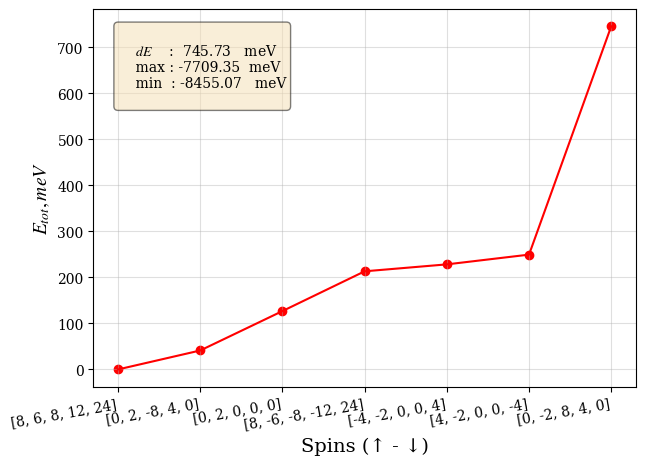

In [7]:
plot_E_tot(sorted_matrix, nn_matrix)

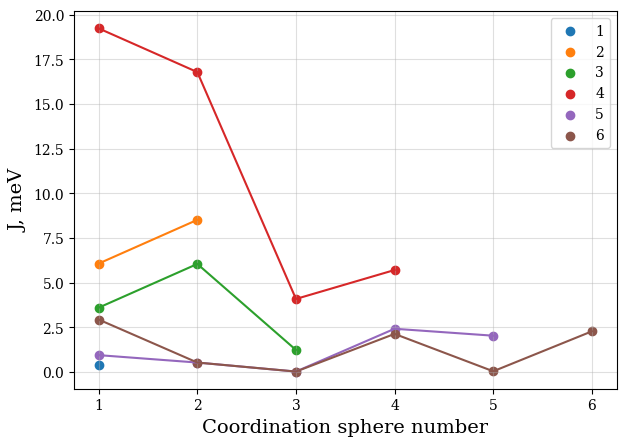

In [8]:
plot_j_values(j_vector_list, input_path)

In [9]:
j_vector_list

[array([0.00039216]),
 array([0.00606943, 0.00851591]),
 array([0.00360066, 0.00604713, 0.00123439]),
 array([0.01923045, 0.01678397, 0.00408827, 0.00570778]),
 array([9.43603071e-04, 5.28998000e-04, 2.45307500e-05, 2.41971107e-03,
        2.03187207e-03]),
 array([2.93508289e-03, 5.28998000e-04, 2.45307500e-05, 2.13224280e-03,
        4.03922548e-05, 2.27597693e-03])]

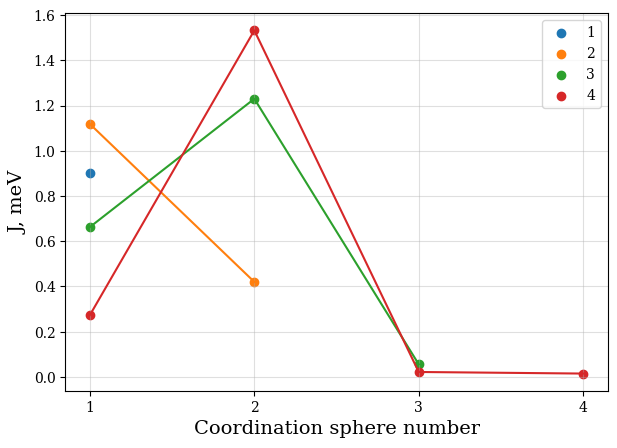

In [10]:
plt.figure(figsize=(7, 5), dpi=100)
j_vector= [[0.90327],
 [1.11820204, 0.42],
 [6.62746111e-01, 1.23, 5.56521079e-02],
 [2.73563221e-01, 1.53245639, 2.15986050e-02, 1.45943584e-02]]
for y in j_vector:
    x = range(1, len(y) + 1)
    plt.scatter(x, y, label=len(x))
    plt.plot(x, y)
plt.xlabel('Coordination sphere number', fontsize = 14)
plt.ylabel('J, meV', fontsize = 14)
plt.grid(alpha=.4)
plt.legend()
plt.xticks(x);

In [11]:
nn = [[2, 2, 4, 2, 2, 2, 2],
[-2, 2, 4, -2, -2, 2, 2],
[-2, 2, 0, -2, 2, 0, 0],
[-2, -2, 4, 0, 0, 2, -2],
[-2, 2, -4, -2, 2, -2],
[0, 0, 4, -2, -2, 2],
[2, 2, 0, -2, -2, 0]]

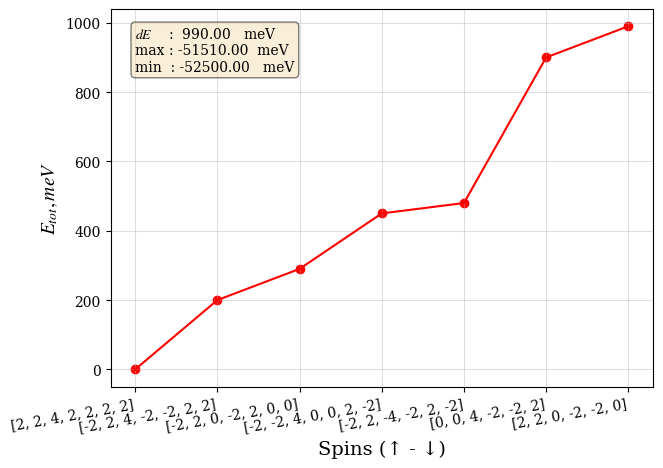

In [12]:
E_list = np.array([-52500, -52300, -52210, -52050, -52020, -51600, -51510])
E_tot_norm = E_list - E_list.min()
max_E_geom = max(E_list)
min_E_geom = min(E_list)
dE_geom = max_E_geom - min_E_geom
text = f"""$dE$    :  {dE_geom:.2f}   meV
max : {max_E_geom:.2f}  meV
min  : {min_E_geom:.2f}   meV"""

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

x = range(1, len(E_tot_norm) + 1)
plt.figure(figsize=(7,5), dpi=100)
plt.scatter(x, E_tot_norm, color='r')
plt.plot(x, E_tot_norm, color='r')
plt.grid(alpha=.4)
plt.xlabel('Spins (\u2191 - \u2193)', fontsize =14)
plt.ylabel(r'$E_{tot},  meV$', fontsize =14)
plt.text(1, max(E_tot_norm), text, verticalalignment='top', bbox=props)
plt.xticks(x, nn, rotation=10, ha='right');

In [13]:
    E_tot_norm = E_tot_mev - E_tot_mev.min()
    max_E_geom = max(E_tot_mev)
    min_E_geom = min(E_tot_mev)
    dE_geom = max_E_geom - min_E_geom
    text = f"""
    $dE$    :  {dE_geom:.2f}   meV
    max : {max_E_geom:.2f}  meV
    min  : {min_E_geom:.2f}   meV
    """
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    
    x = range(1, len(E_tot_norm) + 1)
    plt.figure(figsize=(7, 5), dpi=100)
    plt.scatter(x, E_tot_norm, color='r')
    plt.plot(x, E_tot_norm, color='r')
    plt.text(1, max(E_tot_norm), text, verticalalignment='top', bbox=props)
    plt.grid(alpha=.4)
    plt.xlabel('Spins (\u2191 - \u2193)', fontsize =14)
    plt.ylabel(r'$E_{tot},  meV$', fontsize =14)
    combination_list = [[int(p) for p in i[1:6]] for i in nn_matrix]
    plt.xticks(x, combination_list, rotation=10, ha='right')
    plt.savefig(os.path.join(input_path, 'E_tot_plot.pdf'), bbox_inches='tight')

NameError: name 'E_tot_mev' is not defined

In [ ]:
get_nn_list('../examples/MnB/POSCAR_1', magnetic_atom='Mn')